When using machine learnig models to predict whether a halo is luminous or dark, we find a bias in the predicted two point correlation function for the predicted luminous objects. In this notebook we will explore the origin of this bias

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic
from scipy.interpolate import interp1d
from GaHaCo.src.utils.datautils import get_data, balance_dataset, find_transition_regions
from GaHaCo.src.utils.tpcf import compute_tpcf


In [3]:
output_file = 'merged_dataframe.h5'
data_path = '/cosma6/data/dp004/dc-cues1/tng_dataframes/'
hdf5_filename = data_path + output_file

train, test, test_pos_hydro = get_data(hdf5_filename, 'dark_or_light')


In [10]:
nbins= 15
bins = np.logspace(np.log10(np.min(train.M200c)),
                   12.5, nbins+1)


In [13]:
nluminous, edges, _ = binned_statistic(train.M200c, train.labels, 
                                      statistic = 'mean',
                                      bins = bins)

In [47]:
nluminous_test, edges_test, _ = binned_statistic(test.M200c, test.labels, 
                                      statistic = 'mean',
                                      bins = bins)

In [14]:
# Find x for which y = 0.5
interpolator = interp1d(nluminous, (edges[1:]+edges[:-1])/2.)

center = interpolator(0.5)

end = ((edges[1:]+edges[:-1])/2.)[nluminous == 1.][0]

In [48]:
# Find x for which y = 0.5
interpolator_test = interp1d(nluminous_test, (edges_test[1:]+edges_test[:-1])/2.)

center_test = interpolator(0.5)

end_test = ((edges_test[1:]+edges_test[:-1])/2.)[nluminous_test == 1.][0]

first we check that the train and test distributions contain the same proportion of luminous and dark haloes as a function of mass, which seems to be true in the following plot

Text(2e+12,0.5,'231')

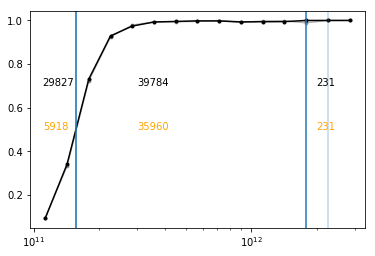

In [50]:
plt.semilogx((edges[1:]+edges[:-1])/2.,
           nluminous,color='black', marker='o',markersize=3)
plt.semilogx((edges_test[1:]+edges_test[:-1])/2.,
           nluminous_test,color='black', marker='o',markersize=3, alpha = 0.3)
plt.axvline(x = center)
plt.axvline(x = end)

plt.axvline(x = center_test, alpha = 0.3)
plt.axvline(x = end_test, alpha = 0.3)

plt.text(1.1e11, 0.7, str(len(train.M200c[train.M200c < center])))
plt.text(1.1e11, 0.5, str(np.sum(train.labels[train.M200c < center] > 0)), color = 'orange')

plt.text(3.e11, 0.7, str(len(train.M200c[(train.M200c >  center) & (train.M200c < end)])))
plt.text(3.e11, 0.5, str(np.sum(train.labels[(train.M200c >  center) & (train.M200c < end)] > 0)), color = 'orange')

plt.text(2.e12, 0.7, str(len(train.M200c[(train.M200c > end)])))
plt.text(2.e12, 0.5, str(np.sum(train.labels[train.M200c > end] > 0)), color = 'orange')


Now, we compare the two point correlation function of all objects in the dark matter only simulation with the one in the hydro simulation for the test set. If these two are different, there is no hope on obtaining an unbiased tpcf from the machine learning algorithm since we are assuming that haloes stay at the same position. However, it is unbiased.

In [51]:
# tpcf dmo positions compared to hydro positions
dmo_positions = np.vstack((test.x_dmo, test.y_dmo, test.z_dmo)).T
r_c, dmo_tpcf =  compute_tpcf(dmo_positions)

hydro_positions = test_pos_hydro
r_c, hydro_tpcf =  compute_tpcf(hydro_positions)

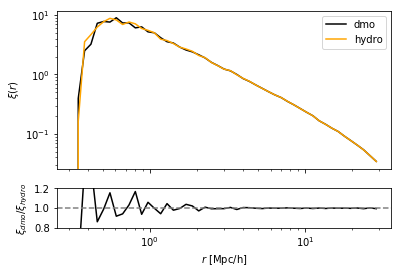

In [54]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True,
              gridspec_kw = {'height_ratios':[4,1]})


axes[0].loglog(r_c, dmo_tpcf, label = 'dmo', color = 'black')
axes[0].loglog(r_c, hydro_tpcf, label = 'hydro', color = 'orange')
axes[1].semilogx(r_c, hydro_tpcf/dmo_tpcf, color = 'black')

axes[1].axhline(y = 1., color='gray', linestyle='dashed')
axes[1].set_ylim(0.8,1.2)
axes[0].set_ylabel(r'${\xi}(r)$')
axes[1].set_ylabel(r'${\xi}_{dmo}/\xi_{hydro}$')

axes[1].set_xlabel(r'$r$ [Mpc/h]')
axes[0].legend()

We now check the difference in clustering of luminous and dark haloes, which is as expected different. Luminous haloes are more massive and therefore more clustered.

In [45]:
# tpcf dark compared to luminous
dark = test[test.labels == 0]
dark_positions = np.vstack((dark.x_dmo, dark.y_dmo, dark.z_dmo)).T
r_c, dark_tpcf =  compute_tpcf(dark_positions)

luminous = test[test.labels > 0]
luminous_positions = np.vstack((luminous.x_dmo, luminous.y_dmo, luminous.z_dmo)).T
r_c, luminous_tpcf =  compute_tpcf(luminous_positions)

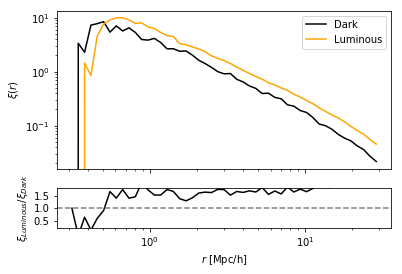

In [46]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True,
              gridspec_kw = {'height_ratios':[4,1]})


axes[0].loglog(r_c, dark_tpcf, label = 'Dark', color = 'black')
axes[0].loglog(r_c, luminous_tpcf, label = 'Luminous', color = 'orange')
axes[1].semilogx(r_c, luminous_tpcf/dark_tpcf, color = 'black')

axes[1].axhline(y = 1., color='gray', linestyle='dashed')
axes[1].set_ylim(0.2,1.8)
axes[0].set_ylabel(r'${\xi}(r)$')
axes[1].set_ylabel(r'${\xi}_{Luminous}/\xi_{Dark}$')

axes[1].set_xlabel(r'$r$ [Mpc/h]')
axes[0].legend()

Another check to test that the training and testing distribution have similar characteristics comparing the clustering of luminous halos in both of them.

In [55]:
luminous_test = test[test.labels > 0]
luminous_test_positions = np.vstack((luminous_test.x_dmo, luminous_test.y_dmo, luminous_test.z_dmo)).T
r_c, luminous_test_tpcf =  compute_tpcf(luminous_test_positions)

luminous_train = train[train.labels > 0]
luminous_train_positions = np.vstack((luminous_train.x_dmo, luminous_train.y_dmo, luminous_train.z_dmo)).T
r_c, luminous_train_tpcf =  compute_tpcf(luminous_train_positions)


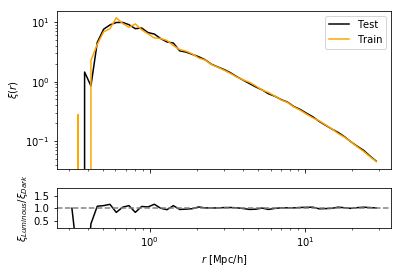

In [57]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True,
              gridspec_kw = {'height_ratios':[4,1]})


axes[0].loglog(r_c, luminous_test_tpcf, label = 'Test', color = 'black')
axes[0].loglog(r_c, luminous_train_tpcf, label = 'Train', color = 'orange')
axes[1].semilogx(r_c, luminous_test_tpcf/luminous_train_tpcf, color = 'black')

axes[1].axhline(y = 1., color='gray', linestyle='dashed')
axes[1].set_ylim(0.2,1.8)
axes[0].set_ylabel(r'${\xi}(r)$')
axes[1].set_ylabel(r'${\xi}_{Luminous}/\xi_{Dark}$')

axes[1].set_xlabel(r'$r$ [Mpc/h]')
axes[0].legend()